# Define the libraries

In [59]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal

# Define the functions 

In [60]:
def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Figuur,player,df): 
    
    #Define starting en stopping positions for the CSV data
    Start = int((((OncourtFrame - OncourtVideo)*100) + Begin/10) - Mistake*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    Timestamp = Time[Start:Stop]
    
   # -----------------------------------------------------------------------
        #LowPass Filter DON'T TOUCH
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
   # -----------------------------------------------------------------------
        #Operations I have to do for user story   UNDERSTAND WHAT SUB AND CONV TRY TO EXPLAIN
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    
    #I set the var below as Conv_temp cbeause i want to try new calculations
    Conv_temp = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    #Conv2 never sees use
    Conv2 = (abs(filtered_FrameRotationspeed+filtered_WheelRotationspeed))/filtered_FrameRotationspeed
    
    
    
    
    #FOR TOMORROW TRY CHANGING UNDERSTAINDING THE IMPACT OF THE CHANGES IN THE
    # DEGREE OF DISCRETE DIFFERENCE AND ALSO TRY ADDING NEW OPERATIONS
    #(ASK MARTIJN IF I GET STUCK OR NEED IDEAS)
    
    
    
    
    
    
    #Diff = arr[i+1] - arr[i]
    number = 8#this variable is for me to only change one number instead of various parameters 1by1
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=number)
    DiffFrame = np.insert(DiffFrame,[0]*number,0)#insert 0 to make the sizes match
    #print(DiffFrame)      SEGUIR ESTUDIANDO LOS CMBIOS
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=3)
    DiffWheel = np.insert(DiffWheel,[0]*3,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    #same as conv but doesn´t see use

  # -----------------------------------------------------------------------
  
    #Visualize operations done (lower row of the subplot)
    fig, ax = plt.subplots(2,2)
    
    ax[1,1].plot(Timestamp,Conv1,'r')
    ax[1,0].plot(Timestamp,abs(DiffFrame),'b')
    
   # -----------------------------------------------------------------------
    
    
    #Set all data into a datafram including Sub, Conv1->Conv, DiffFrame, DiffWheel
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1,'Conv2':Conv2, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv', 'Conv2','DiffFrame','DiffWheel'])
    
    # -----------------------------------------------------------------------
    
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    #when printing the data chunks we see that it prints in sets of 1.5k values
    #those which are divided in sets of 50, this is why we get when asking for max values
    #30 values per iteration
    
    
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    

    #print(Data_chunks)
  # -----------------------------------------------------------------------
    #print(Data_chunks['Conv']) isnt possible

    #  Detect Sprints
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
    
  # -----------------------------------------------------------------------

    #Detect rotation
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    count = 0
    count2 = 0#used to detect when one value enters and starts rotation
    count3 = 0#used to detect if the value makes rotation keep or stop
    #change the values
    #try adding operations instead of difframe
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and Rotate == False:
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75:#si abs menor que num sigue siendo rotation 
            # and abs(chunks['DiffFrame'].max()) > 0.01:#Rotate =True is implicit
            
            Rotate = True
            Stop = False
        elif Stop == False:#Rotate==True and the previous conditions aren´t met, thats implicit
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
        print(abs(chunks['Conv2'].mean()))
        #print(count, '   ', chunks['FrameRotationspeed'].max())
        
        #count +=1
        #print(count2, count3)
        #    print(count)
        #print(count, '   ', (chunks['FrameRotationspeed'].max()))
        #this prints out the maximum values per
        #set of values on each iterations
    
    #print(Startrotate, Stoprotate)
    
    # -----------------------------------------------------------------------
    
    #Pop small sprints out 
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint)-1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 2:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1
    
    
   # -----------------------------------------------------------------------


    #Plot graph
    ax[0,0].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    ax[0,1].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    #ROJO -> WheelRotationSpeed
    #AZUL -> FrameRotationSpeed
    
  # -----------------------------------------------------------------------
        
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax[0,0].axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax[0,0].axvline(x=Stop, color = 'm')
    #ax[0,0].legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax[0,0].set_xlabel('Time (sec)')
    ax[0,0].set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(timedelta(seconds=(int(Begin/1000)-Mistake))))
    
    #Plot the vertical lines in plot 2
    for Start in Startrotate:
        ax[0,1].axvline(x=Start, color = 'g')
    for Stop in Stoprotate:
        ax[0,1].axvline(x=Stop, color = 'm')
    

# Visualize the data

###      Define player and match

In [61]:
Player = 8
Game = 2

### Insert data player

In [62]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Action = pd.read_csv('Ned_DUI_Game_' + str(Game) + '.csv')
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.0000,0.00000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1,0.000000,0.0,0.0,0.0000,0.00000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2,0.000000,0.0,0.0,0.0000,0.00000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.000
3,0.000000,0.0,0.0,0.0000,0.00000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,0.000000,0.0,0.0,0.0000,0.00000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767580,-0.141610,4995.7,4011.8,-5.7383,-0.15038,7675.80,-0.28778,0.70778,-7.4978,-20.168,6.3622,3.8344,-21.853
767581,-0.091962,4995.7,4011.7,-5.9568,-0.15179,7675.80,-0.42636,0.77000,-7.7127,-20.216,6.3280,3.6960,-29.739
767582,-0.041869,4995.7,4011.6,-6.2542,-0.15271,7675.80,-0.45500,0.70000,-8.0150,-20.104,6.4960,3.5840,NaN
767583,NaN,NaN,NaN,NaN,NaN,NaN,-0.34222,0.51333,-8.3456,-19.880,6.7511,3.3444,NaN


# Define boundaries

## Get timestamps from CSV

In [63]:
df_Action_Player = df_Action.loc[df_Action["Players Group Box"] == ("Player " + str(Player))]
df_Action_Player_Fast_defence = df_Action_Player.loc[df_Action_Player["Player"] == "Fast defence"]#.iloc[::-1]
Timestamp = df_Action_Player_Fast_defence.Position.to_numpy()
print(len(Timestamp))
Timestamp

7


array([1311200, 2872960, 3705560, 3969520, 4092760, 4356240, 4397320])

### Sychronize

Times consist of the oncourt times in the video and the oncourt frames in Matlab

In [64]:
df_Sync = pd.read_csv('Sync_match_' + str(Game) + '.csv')
df_Sync_Player = df_Sync.loc[df_Sync["Player"] == Player]
Times = df_Sync_Player[["Video","Matlab"]].to_numpy()
Times[0][1]

3390.4

In [65]:
Error = [6,6,6,4,6,6,6,6,6,8,8]
print(len(Error))

11


### Visualize

2.7019873782275545
5.591234487982389
2.2907090682185087
2.1845106592167016
6.658024368587562
3.286303813259154
0.14813076606790568
0.2750159127011843
20.275848942784105
23.204415883251173
2.61592273524112
3.6210002651749833
8.533070344313286
6.409275882350788
21.094096800040905
364.5103277167085
78.49341523761464
175.72247669397586
17.87504674256261
2.037393165320847
13.497863404630937
19.6279618995289
7.346973785275318
4.525222076853206
4.335718093106446
4.849223797860788
2.2277722846544736
5.3048162728563515
138.8600270428167
3.057496246016271
0.9269451718887102
15.058872672044126
3.41556280251605
2.278911240914269
3.170040609027211
1.0742027955410063
0.2441030725937271
0.46484664888429994
0.5257680399905623
0.11329470396189632
0.7178175844005797
0.5927296231633734
0.6780193358970902
8.223192374158877
0.7333262827700024
2.182087341982227
19.412024684164138
3.612049073762151
2.4912924726671615
93.9621545167989
41.67309309508222
12.499835444518423
5.933722614024183
11.35773998300619
33

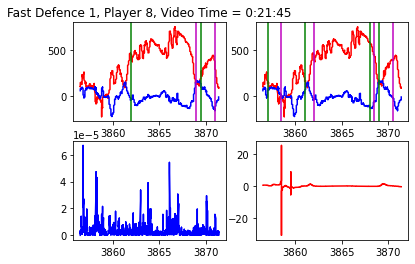

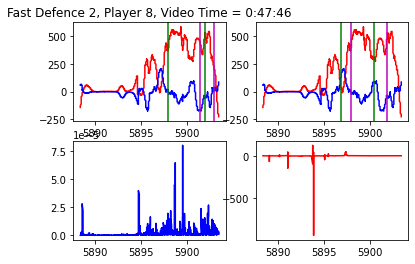

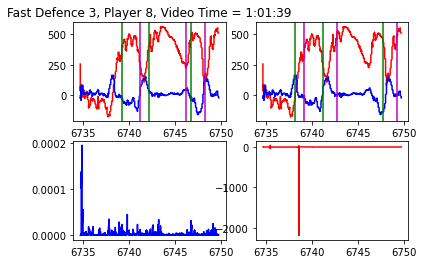

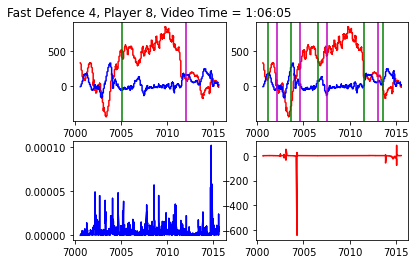

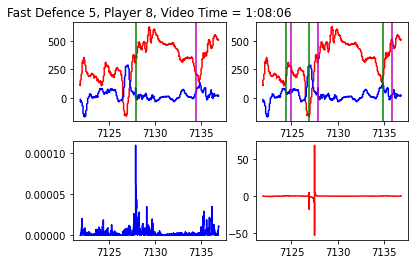

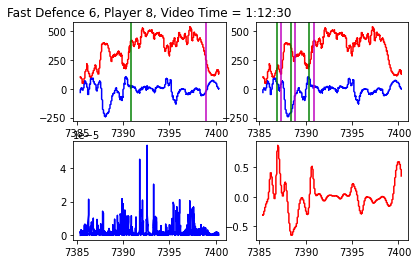

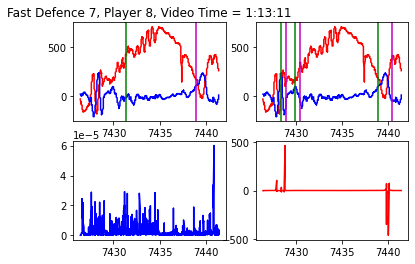

In [66]:
Quator = 0;
count = 0
for i in range(0,len(Timestamp)):#this loop happens 7 times
    if Quator < (len(Times)-1):
        if Timestamp[i] >= (Times[Quator+1][0] * 1000):
            Quator = Quator + 1
    PlotData(Timestamp[i], 15, Error[i], Times[Quator][1], Times[Quator][0], df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),df_Action)
    


In [67]:
a=3
b=3
(a==b)==True

True